# 1 - Data cleaning + Weights definition

In [1]:
from matplotlib import pyplot as plt
from utils.utils import *
import utils.promethee_functions as pf
import utils.clustering_functions as cf

data = read_data()
# Nb of criteria
K = data.columns.shape[0] # Nb of criteria
L = data.iloc[0]["co2prod"].shape[0] # Length of the time series

W = [1/K for i in range(K)] # Weights of the criteria (equal weights)
Q = [4, 0.3, 40,  0.4, 4, 2] # Indifference thresholds
P = [28, 0.9, 80, 1, 20, 12] # Preference thresholds

Weight_vector = [1/L for _ in range(L)] # Equal weights times

utils.py Loading
Reading HDI dataset
co2prod: min=0.0, max=33.3863
hdi: min=0.257, max=0.967
le: min=37.105, max=85.473
gdi: min=0.383, max=1.041
eys: min=3.5751, max=23.2477
mys: min=1.4606, max=14.2559


In [2]:
def G_Kmedoid(data, W, P, Q, Weight_vector, k=3, prototype_method="random"):
    """ 
    Function that receives the raw dataset and creates the clusters using the K-Medoid algorithm using Promethee Gamma as the distance matrix
    - data: pd.DataFrame with the raw dataset - iso3 as index and the criteria as columns names
    - W: list of weights for each criteria - must sum to 1
    - P: list of P thresholds for each criteria - must be > 0
    - Q: list of Q thresholds for each criteria - must be >= 0
    - Weight_vector: list of weights for each time point - must sum to 1
    - k: number of clusters to create
    """
    # Verify that the weights sum to 1
    print("Verifying the input data...")
    print("Shape of the dataset:", data.shape)

    if sum(W) != 1:
        raise ValueError("The weights must sum to 1")
    
    if len(W) != data.shape[1] or len(P) != data.shape[1] or len(Q) != data.shape[1]:
        raise ValueError("The number of weights, P and Q thresholds must be equal to the number of criteria")
    
    # Verify that the P thresholds are > 0
    if any([p <= 0 for p in P]):
        raise ValueError("The P thresholds must be > 0")
    
    # Verify that the Q thresholds are >= 0
    if any([q < 0 for q in Q]):
        raise ValueError("The Q thresholds must be >= 0")
    
    if sum(Weight_vector) != 1:
        raise ValueError("The time weight vector must sum to 1")
    
    if len(Weight_vector) != data.iloc[0]["co2prod"].shape[0]:
        raise ValueError("The time weight vector must have the same length as the time series")
    
    print("Input data verified successfully!\n")

    # Get the criteria names
    alternatives = data.index

    # Computing the distance matrix
    print("Computing the distance matrix using Promethee Gamma...")
    phi_c_all = pf.get_all_Phi_c(data, P, Q)
    eta = pf.get_eta_matrix(data, phi_c_all, W)
    agg_eta = pf.aggregate_all_series(eta, Weight_vector)
    dist_matrix = pd.DataFrame(agg_eta, index=alternatives, columns=alternatives)
    print("Distance matrix computed successfully!\n")

    # Run the K-Medoid algorithm
    print("Running the K-Medoid algorithm...")
    medoids, clusters, iter = cf.K_Medoid_Eta(alternatives, dist_matrix, k, prototype_method=prototype_method, print_results=False)

    print("Converged after", iter, "iterations\nMedoids", medoids ,"\n")

    # Print the clusters one by one
    for i, cluster in enumerate(clusters):
        print("Cluster with Medoid", medoids[i])
        print(clusters[cluster], "\n")

    return medoids, clusters

medoids, clusters = G_Kmedoid(data, W, P, Q, Weight_vector, k=5, prototype_method="random")

Verifying the input data...
Shape of the dataset: (72, 6)
Input data verified successfully!

Computing the distance matrix using Promethee Gamma...


c:\Users\raphu\Documents\ULB\MA2\ulb-master-thesis\code\src\utils\promethee_functions.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]


Distance matrix computed successfully!

Running the K-Medoid algorithm...
Converged after 3 iterations
Medoids ['ISL' 'ISR' 'AUS' 'BHR' 'BWA'] 

Cluster with Medoid ISL
['ISL', 'HKG'] 

Cluster with Medoid ISR
['ISR', 'BEL'] 

Cluster with Medoid AUS
['AUS', 'ARG', 'AUT', 'BHS', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'JPN', 'MLT', 'NLD', 'NZL', 'POL', 'PRT', 'ESP', 'SWE', 'CHE', 'GBR'] 

Cluster with Medoid BHR
['BHR', 'ALB', 'BGD', 'BRB', 'BOL', 'BGR', 'BDI', 'CHL', 'CHN', 'DOM', 'EGY', 'GHA', 'HTI', 'HND', 'IND', 'IDN', 'IRN', 'MUS', 'MEX', 'MAR', 'NPL', 'PAK', 'PRY', 'PHL', 'ROU', 'LCA', 'ZAF', 'LKA', 'SDN', 'SYR', 'THA', 'TUR', 'URY', 'ZMB'] 

Cluster with Medoid BWA
['BWA', 'BRN', 'CAN', 'KOR', 'NOR', 'SAU', 'SGP', 'TTO', 'USA'] 



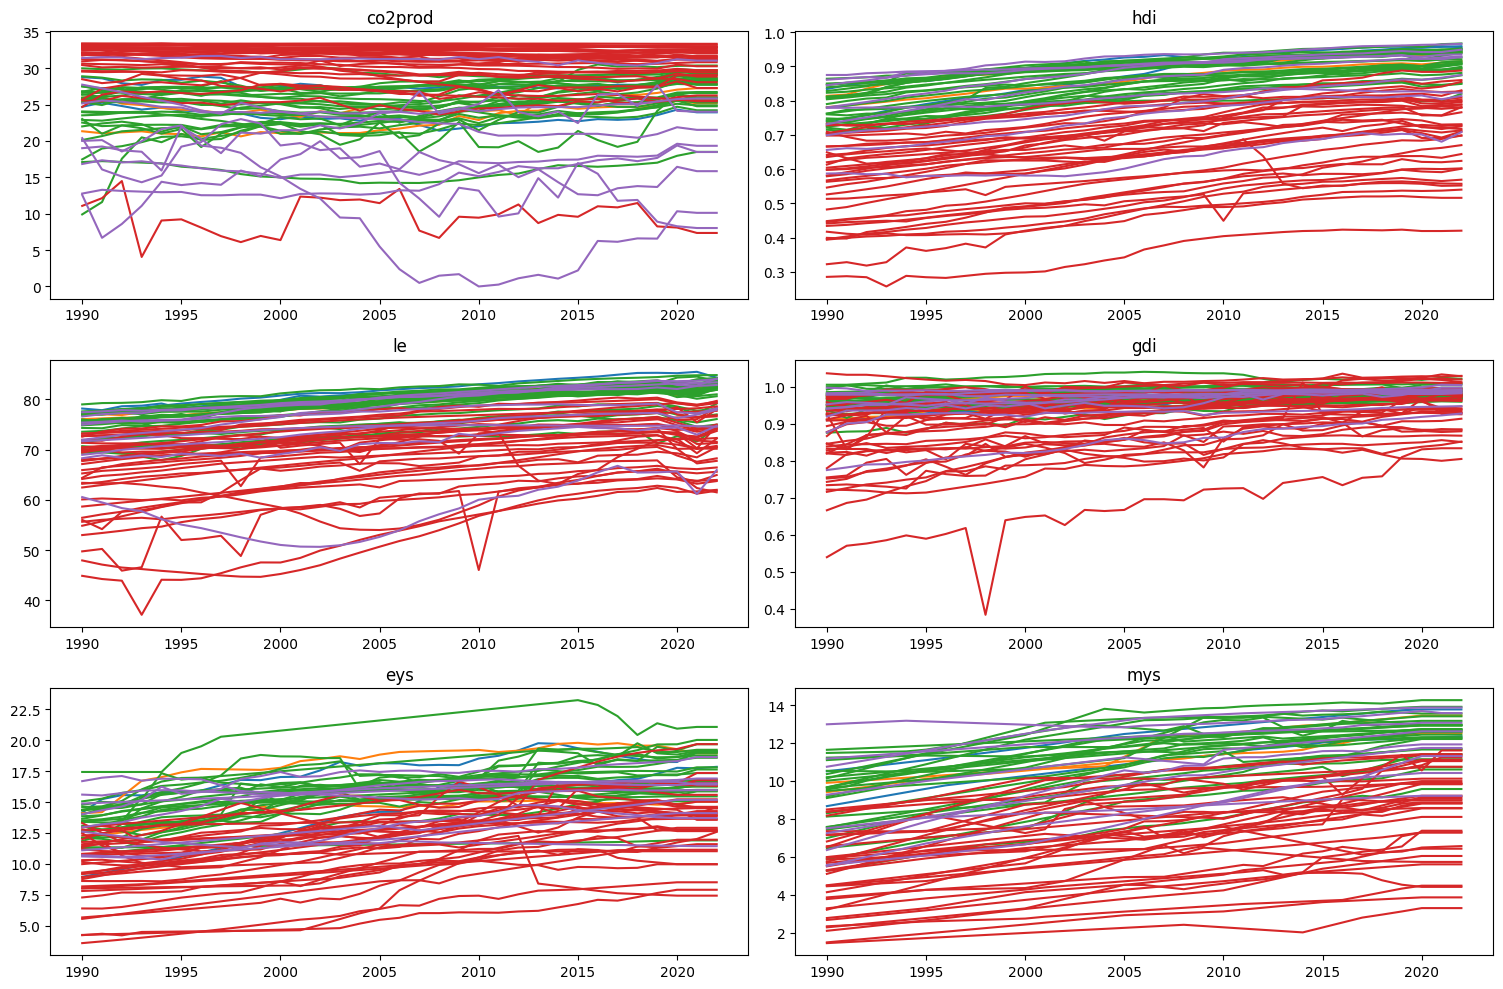

In [3]:
groups = []
for i, cluster in enumerate(clusters):
    groups.append(clusters[cluster])

# Plot the clusters
plot_cluster(groups, data, False)

## Test on a smaller dataset

In [29]:
group0 = ["PAK", "SDN", "BDI", "HTI"]
group1 = ["EST", "CZE", "MLT", "SGP", "IRL"]
group2 = ["CHE", "ISL", "NZL", "SWE"]

all_groups = group0 + group1 + group2

data = data.loc[all_groups]

# Replace the names of the countries: grp_number_ISO3
# data.index = ["0_" + i for i in group0] + ["1_" + i for i in group1] + ["2_" + i for i in group2]

get_min_max_criteria(data, False)
# Nb of criteria
K = data.columns.shape[0] # Nb of criteria
L = data.iloc[0]["co2prod"].shape[0] # Length of the time series

# W = [1/K for i in range(K)] # Weights of the criteria (equal weights)
W = [1,1,0,0,0,0] #co2prod, hdi,le, gdi, eys, mys

W = [w/sum(W) for w in W]

Q = [10, 0.3, 40,  0.4, 4, 2] # Indifference thresholds
P = [28, 0.9, 80, 1, 18, 12] # Preference thresholds

Weight_vector = [1/L for _ in range(L)] # Equal weights times

co2prod: min=9.9, max=33.3863
hdi: min=0.257, max=0.967
le: min=37.105, max=84.255
gdi: min=0.383, max=1.041
eys: min=3.5751, max=19.7613
mys: min=1.4606, max=13.9041


Verifying the input data...
Shape of the dataset: (13, 6)
Input data verified successfully!

Computing the distance matrix using Promethee Gamma...
Distance matrix computed successfully!

Running the K-Medoid algorithm...
Converged after 3 iterations
Medoids ['SWE' 'PAK' 'SDN' 'MLT'] 

Cluster with Medoid SWE
['SWE', 'CHE', 'ISL', 'NZL'] 

Cluster with Medoid PAK
['PAK', 'HTI'] 

Cluster with Medoid SDN
['SDN', 'BDI'] 

Cluster with Medoid MLT
['MLT', 'EST', 'CZE', 'SGP', 'IRL'] 



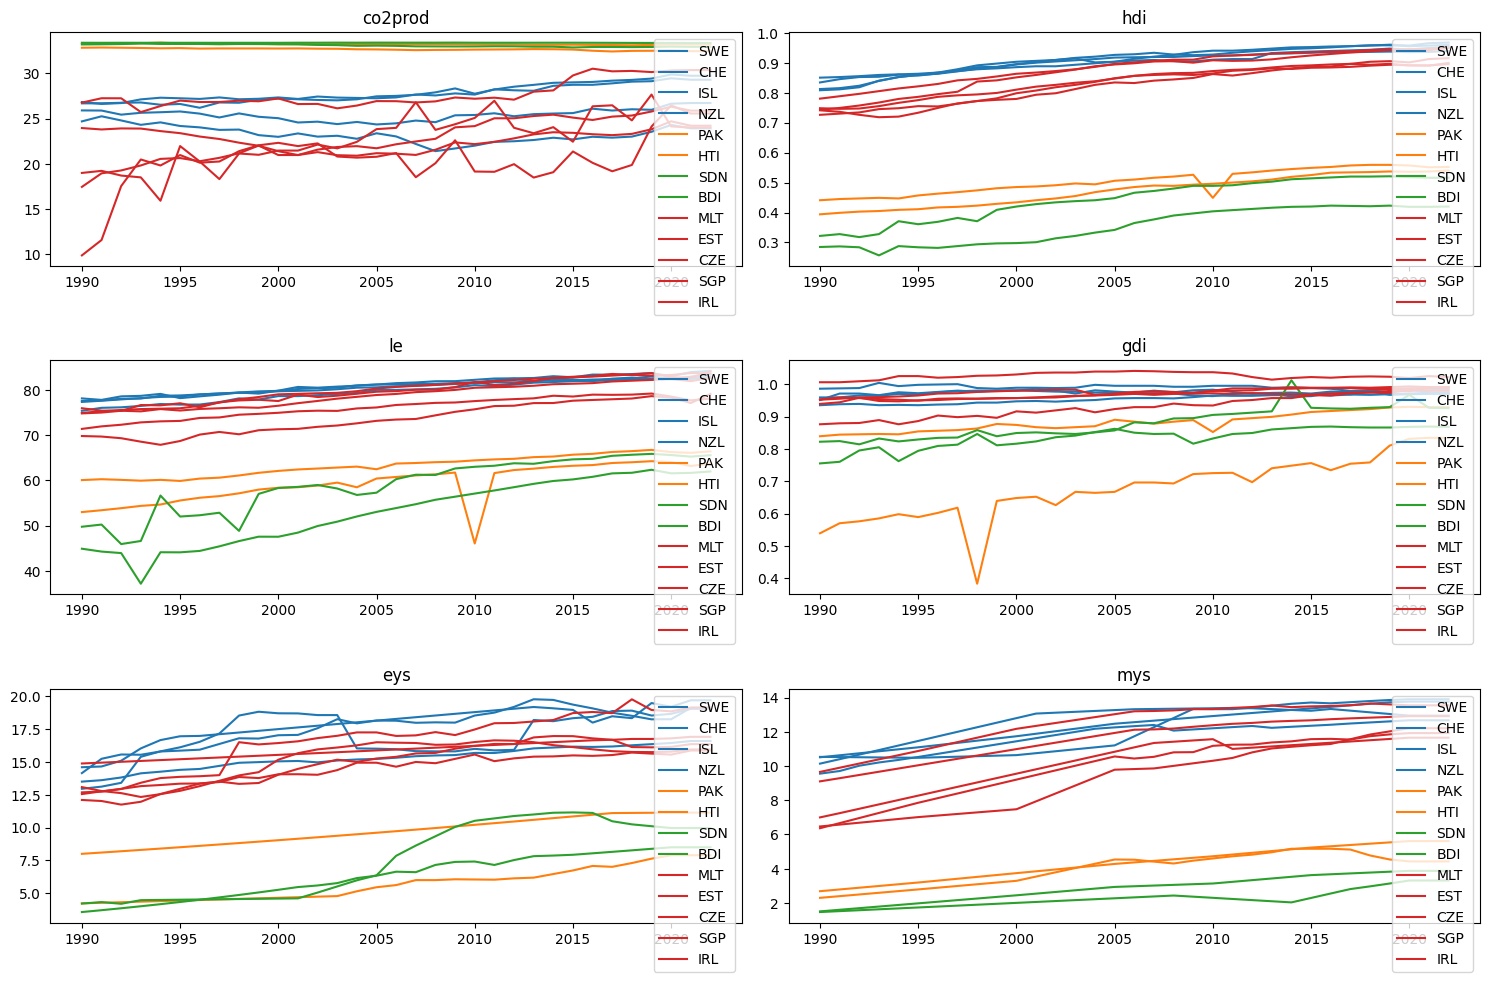

In [31]:
medoids, clusters = G_Kmedoid(data, W, P, Q, Weight_vector, k=4, prototype_method="random")
groups = []
for i, cluster in enumerate(clusters):
    groups.append(clusters[cluster])

# Plot the clusters
plot_cluster(groups, data, True)